# 项目：欧洲国家足球分析

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> 这个足球数据库来自 [Kaggle](https://www.kaggle.com/hugomathien/soccer)，它包含了从2008年到2016年间，几个欧洲国家的足球比赛（soccer matches）、球员（players）和球队（teams）的数据。该数据库存储在 SQLite 数据库中。

**该报告主要分析如下内容**
- 哪支球队在这段时间内的表现最好？ 
- 哪位球员受罚最多？

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

database = 'database.sqlite'

<a id='wrangling'></a>
## 数据整理


In [2]:
#连接数据库
conn = sqlite3.connect(database)

In [3]:
#先看一下都有哪些table
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


### 得到各个表的DataFrame

In [4]:
# 得到DataFrame
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
leagues = pd.read_sql("""SELECT *
                        FROM League;""", conn)
matches = pd.read_sql("""SELECT *
                        FROM Match;""", conn)
players = pd.read_sql("""SELECT *
                        FROM Player;""", conn)
player_attributes = pd.read_sql("""SELECT *
                        FROM Player_Attributes;""", conn)
teams = pd.read_sql("""SELECT *
                        FROM Team;""", conn)
team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes;""", conn)

In [5]:
# 在Notebook中显示更多的行和列
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth',1500)


### 因为Match、Country和League这3个表格是分开的，所以需要合并到一起以得到含有国家名及联赛的名字。利用SQL的'JOIN'指令即可完成此合并。


In [6]:
detailed_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal,
                                        CASE WHEN home_team_goal > away_team_goal THEN HT.team_long_name
                                             WHEN home_team_goal = away_team_goal THEN 'all_win'
                                             ELSE AT.team_long_name END AS winner
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                
                                ORDER by date
                                ;""", conn)
# detailed_matches.tail()
detailed_matches.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,winner
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2,FC Basel
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1,FC Aarau
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2,FC Vaduz
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2,FC Zürich
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0,FC Basel


### 把date格式改为datetime64的格式

In [8]:
detailed_matches['date'] = pd.to_datetime(detailed_matches['date'])

In [9]:
detailed_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
id                25979 non-null int64
country_name      25979 non-null object
league_name       25979 non-null object
season            25979 non-null object
stage             25979 non-null int64
date              25979 non-null datetime64[ns]
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
winner            25979 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 2.2+ MB


### 检查是否有重复的行

In [10]:
sum(detailed_matches.duplicated())

0

### 检查是否有NaN

In [13]:
detailed_matches[detailed_matches.home_team_goal.isna()]

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,winner


<a id='eda'></a>
## 探索性数据分析


### 哪支球队在这段时间内的表现最好？

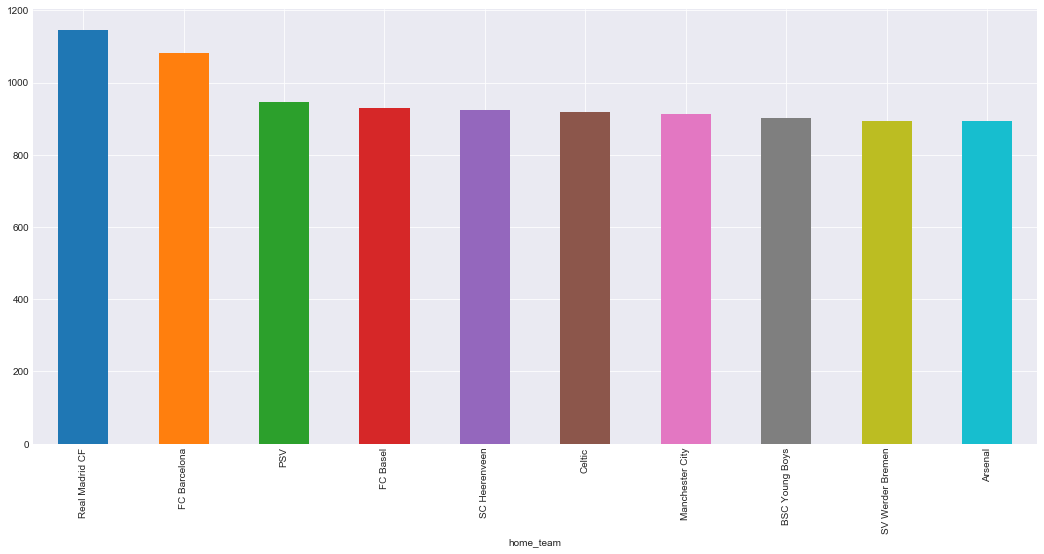

In [14]:
group_home = detailed_matches.groupby('home_team')
# group_home = detailed_matches.groupby(['home_team','league_name'])
all_goal_home1 = group_home.sum()['home_team_goal']
all_goal_home2 = group_home.sum()['away_team_goal']
all_goal_home = all_goal_home1 + all_goal_home2

group_away = detailed_matches.groupby('away_team')
# group_away = detailed_matches.groupby(['away_team', 'league_name'])
all_goal_away1 = group_away.sum()['home_team_goal']
all_goal_away2 = group_away.sum()['away_team_goal']
all_goal_away = all_goal_away1 + all_goal_away2

all_goal = all_goal_home + all_goal_away
goal_max = all_goal.sort_values(ascending = False).head(10)
goal_max.plot(kind='bar', figsize=(18,8));
# all_goal.plot(kind='hist')

In [43]:
goal_max

home_team
Real Madrid CF      1147
FC Barcelona        1081
PSV                  946
FC Basel             930
SC Heerenveen        925
Celtic               918
Manchester City      913
BSC Young Boys       902
SV Werder Bremen     894
Arsenal              893
dtype: int64

#### 上图列出了进球数最多的10支球队

> ###### _从上述程序可以看出，Real Madrid CF队总共进球1147个，表现最好_

***

## 下面以进球数最多的Real Madrid、FC Barcelona两个队为例，按赛季查看进球数

### 按season、home_team得到home_team_goal进球数

In [18]:
df_home = detailed_matches.groupby(['season', 'home_team'], as_index=False).sum()[['season', 'home_team', 'home_team_goal']]

In [19]:
df_home.rename(columns={'home_team':'team','home_team_goal':'team_goal'}, inplace=True)

In [20]:
df_home.head()

,season,team,team_goal
0,2008/2009,1. FC Köln,14
1,2008/2009,AC Bellinzona,29
2,2008/2009,ADO Den Haag,21
3,2008/2009,AJ Auxerre,18
4,2008/2009,AS Monaco,26


### 按season、away_team得到away_team_goal进球数

In [21]:
df_away = detailed_matches.groupby(['season', 'away_team'], as_index=False).sum()[['season', 'away_team', 'away_team_goal']]

In [22]:
df_away.rename(columns={'away_team':'team','away_team_goal':'team_goal'}, inplace=True)

In [23]:
df_away.head()

,season,team,team_goal
0,2008/2009,1. FC Köln,21
1,2008/2009,AC Bellinzona,15
2,2008/2009,ADO Den Haag,20
3,2008/2009,AJ Auxerre,17
4,2008/2009,AS Monaco,15


### 按照team、和season来执行merge

In [24]:
df_all = pd.merge(df_home, df_away, on=['team', 'season'])

In [25]:
df_all.head()

,season,team,team_goal_x,team_goal_y
0,2008/2009,1. FC Köln,14,21
1,2008/2009,AC Bellinzona,29,15
2,2008/2009,ADO Den Haag,21,20
3,2008/2009,AJ Auxerre,18,17
4,2008/2009,AS Monaco,26,15


### 添加team_goal列，得到做为主队和客队的总进球数

In [33]:
df_all['team_goal'] = df_all.team_goal_x + df_all.team_goal_y

### 删除无用列

In [35]:
df_all.drop(['team_goal_x', 'team_goal_y'], axis=1, inplace=True)

In [36]:
df_all.head()

,season,team,team_goal
0,2008/2009,1. FC Köln,35
1,2008/2009,AC Bellinzona,44
2,2008/2009,ADO Den Haag,41
3,2008/2009,AJ Auxerre,35
4,2008/2009,AS Monaco,41


In [75]:
# df = df_all[(df_all['team'] == 'Real Madrid CF') | (df_all['team'] == 'FC Barcelona') |
#            (df_all['team'] == 'PSV') | (df_all['team'] == 'FC Basel') |
#            (df_all['team'] == 'SC Heerenveen')]

#### 只取Real Madrid CF和FC Barcelona两个队

In [76]:
df = df_all[(df_all['team'] == 'Real Madrid CF') | (df_all['team'] == 'FC Barcelona')]

In [85]:
df

,season,team,team_goal
44,2008/2009,FC Barcelona,105
136,2008/2009,Real Madrid CF,83
233,2009/2010,FC Barcelona,98
318,2009/2010,Real Madrid CF,102
420,2010/2011,FC Barcelona,95
503,2010/2011,Real Madrid CF,102
601,2011/2012,FC Barcelona,114
689,2011/2012,Real Madrid CF,121
779,2012/2013,FC Barcelona,115
869,2012/2013,Real Madrid CF,103


In [86]:
df_sum = df.groupby(['team', 'season'], as_index=True).sum()
df_sum

team_goal
team           season              
FC Barcelona   2008/2009        105
               2009/2010         98
               2010/2011         95
               2011/2012        114
               2012/2013        115
               2013/2014        100
               2014/2015        110
               2015/2016        112
Real Madrid CF 2008/2009         83
               2009/2010        102
               2010/2011        102
               2011/2012        121
               2012/2013        103
               2013/2014        104
               2014/2015        118
               2015/2016        110

In [87]:
goal_sum = df.groupby(['team', 'season'], as_index=True).sum()['team_goal']

In [88]:
goal_sum

team            season   
FC Barcelona    2008/2009    105
                2009/2010     98
                2010/2011     95
                2011/2012    114
                2012/2013    115
                2013/2014    100
                2014/2015    110
                2015/2016    112
Real Madrid CF  2008/2009     83
                2009/2010    102
                2010/2011    102
                2011/2012    121
                2012/2013    103
                2013/2014    104
                2014/2015    118
                2015/2016    110
Name: team_goal, dtype: int64

In [91]:
FC_goals = goal_sum['FC Barcelona']

In [93]:
Real_goals = goal_sum['Real Madrid CF']

In [105]:
ind = np.arange(len(FC_goals))  # 组的 x 坐标位置
width = 0.25       # 条柱的宽度

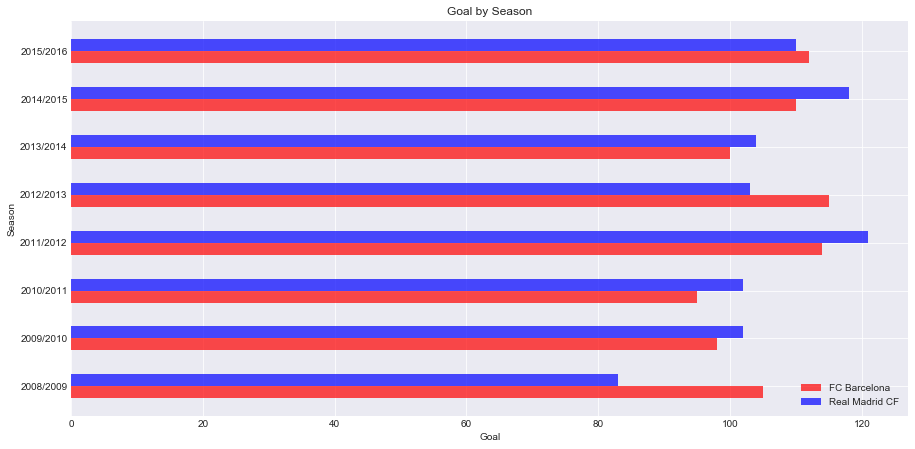

In [133]:
plt.figure(figsize=(15, 7.27))
# 绘制条柱
fc_bars = plt.barh(ind, FC_goals, width, color='r', alpha=.7, label='FC Barcelona')
real_bars = plt.barh(ind + width, Real_goals, width, color='b', alpha=.7, label='Real Madrid CF')

# 标题和标签
plt.ylabel('Season')
plt.xlabel('Goal')
plt.title('Goal by Season')
locations = ind + width / 2  # x 坐标刻度位置
labels = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']  # x 坐标刻度标签
# plt.xticks(locations, labels)
plt.yticks(locations, labels)

# 图例
plt.legend();

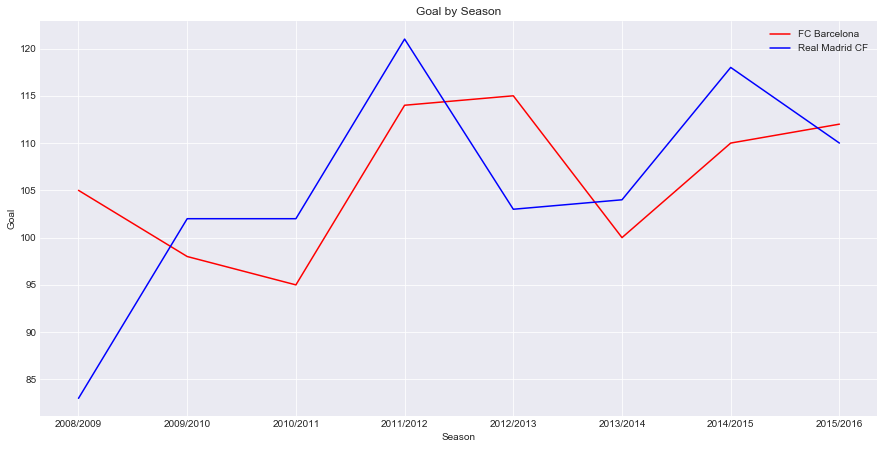

In [152]:
plt.figure(figsize=(15, 7.27))
plt.plot(FC_goals.index, FC_goals.values, color='r', label='FC Barcelona')
plt.plot(Real_goals.index, Real_goals.values, color='b', label='Real Madrid CF')
plt.ylabel('Goal')
plt.xlabel('Season')
plt.title('Goal by Season')
plt.legend();

> 8个赛季中，Real Madrid CF有5个赛季的进球总数比FC Barcelona队要多

### 哪位球员受罚最多？

In [120]:
player_attributes[['player_api_id','penalties']].sort_values(by='penalties',ascending=False).head()

,player_api_id,penalties
149594,39225,96.0
149593,39225,96.0
149592,39225,96.0
149591,39225,96.0
149595,39225,95.0


In [81]:
# 根据受罚最多的player_api_id得到球员姓名
players[players['player_api_id'] == 39225]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
8967,8981,39225,Rickie Lambert,13879,1982-02-16 00:00:00,187.96,170


> ###### _根据penalties属性，球员Rickie Lambert受罚最多_

***

<a id='conclusions'></a>
## 结论

> 本分析是从进球数来判断一个球队是否表现好，可能还存在其他判断依据。Real Madrid CF是2008年到2016年间进球最多的一个球队。

> 在Player_Attributes这个表中，penalties列代表“处罚”之意，根据该列，Rickie Lambert这名球员所受到的处罚最多。可能还存在其他判断条件。